In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn.functional as F


from MODULES.utilities import show_batch, save_obj, load_obj 
from MODULES.utilities import load_json_as_dict, save_dict_as_json, DatasetInMemory
from MODULES.utilities import train_one_epoch, evaluate_one_epoch, test_model, linear_interpolation
from MODULES.vae_model import CompositionalVae

#!pip install moviepy
from IPython.display import Image, display, HTML
import moviepy.editor as mpy
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO #,TraceEnum_ELBO, TraceGraph_ELBO, config_enumerate, JitTraceEnum_ELBO 


torch.Size([8, 1, 10, 10])


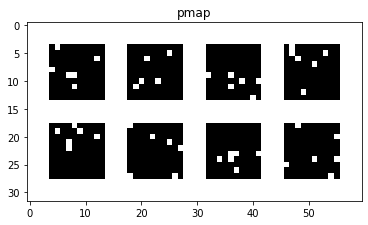

In [2]:
batch_size,ch,w,h = 8, 1, 10, 10
n_peak = 6


ix = (w*torch.rand(batch_size,n_peak)).long()
iy = (h*torch.rand(batch_size,n_peak)).long()
pmap = torch.zeros(batch_size,w,h)
for b in range(batch_size):
    for n in range(n_peak):
        pmap[b,ix[b,n],iy[b,n]]=1.0
        
pmap = pmap.unsqueeze(-3)
print(pmap.shape)

show_batch(pmap, n_col=4, n_padding=4, title="pmap")

tensor([6., 5., 6., 6., 6., 6., 6., 6.])


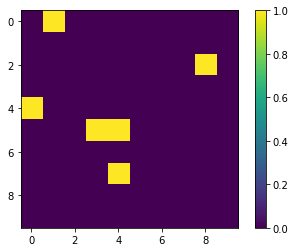

In [140]:
class PSF:
    """ Compute int dr dr' U(|r-r'|) p(r') p(r) =
        int dr p(r) [int dr' U(|r-r'|) p(r') ]
        The double sum can be avoided by making the convolution in square bracket first.
        The potential has the form exp(-0.5 * (r/sdt)^2)
    """
    
    def __init__(self, std_potential, concentration_0, concentration_other):
        self.c0 = concentration_0
        self.c_other = concentration_other 
        self.length_scale = std_potential

        # make a gaussian kernel exp(-0.5*(x/l)^2)
        radius = 3 * self.length_scale # this guarantees that the interaction potential goes to zero at the edges
        self.radius_rounded = int(radius) + 1
        x_mat = torch.linspace(-self.radius_rounded, 
                               self.radius_rounded, 
                               steps=2 * self.radius_rounded + 1).view(-1, 1).float()
        y_mat = x_mat.clone().permute(1, 0)
        r2 = (x_mat ** 2 + y_mat ** 2) / (self.length_scale * self.length_scale)
        kernel = torch.exp(-0.5 * r2)
        self.kernel = (kernel /torch.sum(kernel)).detach()
       
    def _apply_psf(self, x=None):
        # make sure member variables are on the correct device
        if self.kernel.device != x.device:
            self.kernel = self.kernel.to(x.device)
       
        pad = int((self.kernel.shape[-1]-1)*0.5)
        return F.conv2d(input=x,
                        weight=self.kernel[None, None, ...],
                        bias=None,
                        stride=1,
                        padding=pad,
                        dilation=1,
                        groups=1)
    
    def _apply_4_shifts(self, x, shift_size=1):
        input_padded = F.pad(x, pad=(shift_size,shift_size,shift_size,shift_size), 
                             mode='constant', value=0.0)
        shift0 = input_padded[..., shift_size:-shift_size, shift_size:-shift_size]
        shift1 = input_padded[..., :-2*shift_size, shift_size:-shift_size]
        shift2 = input_padded[..., 2*shift_size:, shift_size:-shift_size]
        shift3 = input_padded[..., shift_size:-shift_size, :-2*shift_size]
        shift4 = input_padded[..., shift_size:-shift_size, 2*shift_size:]
        return torch.stack((shift0,shift1,shift2,shift3,shift4), dim=-1)  # stack along a new dimension
    
    def _combine_all_shifts(self, x):
        batch, ch, w, h, n = x.shape
        other_concentration = self.c_other * torch.ones([n-1])
        zeroth_concentration = self.c0 * torch.ones([1])
        concentration = torch.cat((zeroth_concentration, other_concentration), dim=0)
        assert concentration.shape[0] == n
        m = dist.Dirichlet(concentration)
        weight = m.sample([batch,1,w,h])  # all channels will be treated equally        
        return torch.sum(x*weight, dim=-1)  # sum over the n dimension
    
    def make_noisy_pmap(self, x, shift_size=1):
        x1 = self._apply_psf(x)
        x2 = self._apply_4_shifts(x1, shift_size)
        x3 = self._combine_all_shifts(x2)
        return x3
        

plt.imshow(pmap[0,0])
plt.colorbar()
print(torch.sum(pmap, dim=(-1,-2,-3)))

tensor([5.7861, 4.9995, 5.6796, 5.8920, 5.8922, 5.3823, 5.8930, 5.4662])


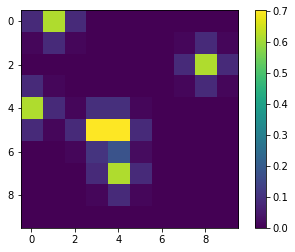

In [141]:
psf = PSF(std_potential=0.5, concentration_0=0.5, concentration_other=0.1)
tmp=psf._apply_psf(pmap)
plt.imshow(tmp[0,0])
plt.colorbar()
print(torch.sum(tmp, dim=(-1,-2,-3)))

tensor([4.8751, 4.7859, 4.9454, 5.9087, 6.1940, 5.3577, 5.2229, 5.5991])


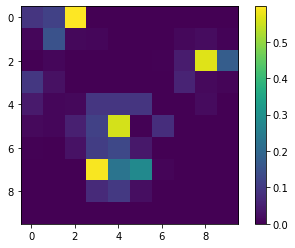

In [153]:
pmap_noisy = psf.make_noisy_pmap(pmap)
plt.imshow(pmap_noisy[0,0])
plt.colorbar()
print(torch.sum(pmap_noisy, dim=(-1,-2,-3)))

In [144]:
pmap_with_psf = psf._apply_psf(pmap)
print(pmap_with_psf.shape)

torch.Size([8, 1, 10, 10])


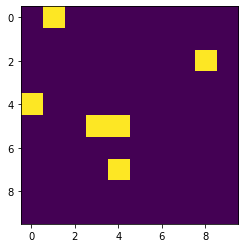

In [101]:
plt.imshow(pmap[0,0])

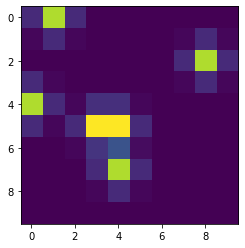

In [102]:
plt.imshow(pmap_with_psf[0,0])

torch.Size([8, 1, 10, 10, 5])


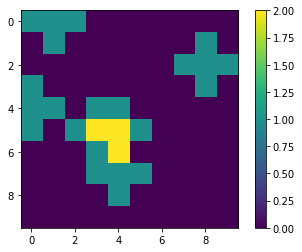

In [103]:
pmap_shifted = psf.apply_4_shifts(pmap,shift_size=1)
print(pmap_shifted.shape)
aa = torch.sum(pmap_shifted, dim=-1)
plt.imshow(aa[0,0])
plt.colorbar()

torch.Size([8, 1, 10, 10])


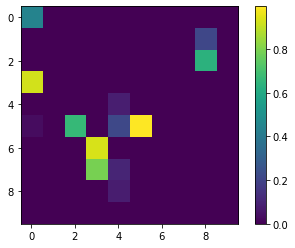

In [108]:
bb = psf.combine_all_shifts(pmap_shifted)
print(bb.shape)
plt.imshow(bb[0,0])
plt.colorbar()

In [105]:
show_batch(pmap_shifted[0].unsqueeze(1), n_col=5, n_padding=4, title="shifts")

AssertionError: 

In [81]:
def combine_4_shifts(input):
    batch, ch, w, h, n = input.shape
    assert ch == 1
    input = input.squeeze(-4)
    concentration = torch.tensor([0.2, 0.1, 0.1, 0.1, 0.1])
    assert concentration.shape[0] == n
    m = dist.Dirichlet(concentration)
    weight = m.sample([batch,w,h])
    assert weight.shape == input.shape
    
   

a1 = apply_4_shifts(a0, size=2)
print(len(a1),a1[0].shape)

input_padded.shape torch.Size([8, 1, 14, 14])
8 torch.Size([1, 5, 10, 10])


In [33]:
import torch.distributions as dist

m = dist.Dirichlet(concentration=torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1]))
w = m.sample([10])
print(w)

m = dist.Dirichlet(concentration=torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0]))
w = m.sample([10])
print(w)

m = dist.Dirichlet(concentration=torch.tensor([10.0, 10.0, 10.0, 10.0, 10.0]))
w = m.sample([10])
print(w)


m = dist.Dirichlet(concentration=torch.tensor([100.0, 100.0, 100.0, 100.0, 100.0]))
w = m.sample([10])
print(w)

tensor([[8.8166e-01, 1.4737e-07, 7.3548e-07, 1.0327e-01, 1.5071e-02],
        [2.4456e-10, 9.9874e-01, 2.1736e-14, 3.5278e-05, 1.2270e-03],
        [7.0948e-06, 5.1717e-01, 4.8115e-01, 1.6703e-03, 3.3253e-20],
        [9.8505e-01, 6.4969e-08, 1.4865e-02, 8.8718e-05, 4.3266e-08],
        [1.3055e-06, 4.0241e-01, 3.1000e-01, 1.3078e-01, 1.5680e-01],
        [1.2857e-01, 6.5765e-08, 3.0511e-11, 2.4301e-01, 6.2842e-01],
        [7.2190e-03, 1.2457e-16, 7.8924e-01, 1.9375e-01, 9.7959e-03],
        [7.6603e-03, 1.6513e-02, 7.1995e-11, 2.1357e-02, 9.5447e-01],
        [2.7417e-03, 7.8946e-08, 1.2429e-03, 9.9602e-01, 1.2923e-07],
        [1.0889e-08, 3.4984e-05, 9.0290e-01, 9.6770e-02, 2.9552e-04]])
tensor([[0.1538, 0.0702, 0.3799, 0.1809, 0.2152],
        [0.0517, 0.3204, 0.1143, 0.0382, 0.4754],
        [0.4464, 0.0742, 0.1839, 0.1293, 0.1663],
        [0.3130, 0.0149, 0.0828, 0.3592, 0.2302],
        [0.1757, 0.3258, 0.2309, 0.2183, 0.0493],
        [0.0091, 0.0659, 0.0790, 0.3808, 0.4652],

In [38]:
WIDTH,HEIGHT = 60,60
m = dist.Dirichlet(concentration=torch.tensor([0.2, 0.1, 0.1, 0.1, 0.1]))
w = m.sample([WIDTH,HEIGHT])
print(w.shape)

torch.Size([60, 60, 5])


###### WIDTH,HEIGHT = 60,60
m = dist.Dirichlet(concentration=torch.tensor([0.2, 0.1, 0.1, 0.1, 0.1]))
w = m.sample([WIDTH,HEIGHT])
print(w)

In [ ]:
m = dist.Dirichlet(concentration=torch.tensor([0.5, 0.2, 0.2, 0.2, 0.2]))
w = m.sample([10])
print(w)

In [ ]:
plt.imshow(pmap[0,0])

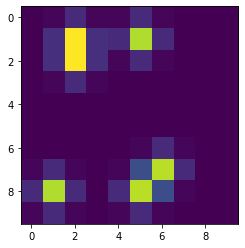

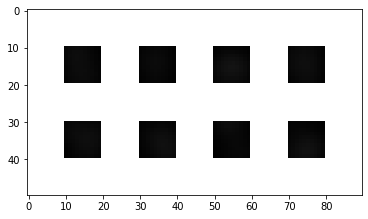

In [28]:
show_batch(a)

In [ ]:
psf_weight =   


n_boxes, batch_size = bounding_box.bx.shape
        small_bb = torch.ones_like(small_weight)
        pad = int(0.5 * self.cropped_height)
        small_weight_padded = F.pad(small_weight, (pad, pad, pad, pad), mode='constant', value=0)
        small_bb_padded = F.pad(small_bb, (pad, pad, pad, pad), mode='constant', value=0)
        bounding_box_few_twice_the_size = BB(bx=bounding_box.bx,
                                             by=bounding_box.by,
                                             bw=2 * bounding_box.bw,
                                             bh=2 * bounding_box.bh)
        cropped_feature_map_twice_the_size = self.cropper(bounding_box=bounding_box_few_twice_the_size,
                                                          big_stuff=unet_features_expanded,
                                                          width_small=2 * self.cropped_width,
                                                          height_small=2 * self.cropped_height)
        
        